# 8장 빅데이터와 Toolz 라이브러리

In [1]:
import numpy as np

with open('data/expr.tsv') as f:
    sum_of_means = 0
    for line in f:
        sum_of_means += np.mean(np.fromstring(line, dtype=int, sep='\t'))
print(sum_of_means)

1463.0


In [2]:
import numpy as np

expr = np.loadtxt('data/expr.tsv')
logexpr = np.log(expr + 1)
np.mean(logexpr, axis=0)

array([ 3.11797294,  2.48682887,  2.19580049,  2.36001866,  2.70124539,
        2.64721531,  2.43704834,  3.28539133,  2.05363724,  2.37151577,
        3.85450782,  3.9488385 ,  2.46680157,  2.36334423,  3.18381635,
        2.64438124,  2.62966516,  2.84790568,  2.61691451,  4.12513405])

## 8.1 스트리밍과 yield

In [3]:
def log_all_standard(input):
    output = []
    for elem in input:
        output.append(np.log(elem))
    return output

def log_all_streaming(input_stream):
    for elem in input_stream:
        yield np.log(elem)

In [4]:
# 랜덤 시드값을 설정한다.
np.random.seed(seed=7)
# 세 자릿수만 표시되도록, 프린트 옵션을 설정한다.
np.set_printoptions(precision=3, suppress=True)

arr = np.random.rand(1000) + 0.5
result_batch = sum(log_all_standard(arr))
print('일괄처리 결과 : ', result_batch)
result_stream = sum(log_all_streaming(arr))
print('스트리밍 결과 : ', result_stream)

일괄처리 결과 :  -48.2409194561
스트리밍 결과 :  -48.2409194561


In [5]:
import numpy as np

def tsv_line_to_array(line):
    lst = [float(elem) for elem in line.rstrip().split('\t')]
    return np.array(lst)

def readtsv(filename):
    print('라인 읽기 시작')
    with open(filename) as fin:
        for i, line in enumerate(fin):
            print(f'라인 {i} 읽기')
            yield tsv_line_to_array(line)
    print('라인 읽기 끝')

def add1(arrays_iter):
    print('1 더하기 시작')
    for i, arr in enumerate(arrays_iter):
        print(f'라인 {i}에 1 더하기')
        yield arr + 1
    print('1 더하기 끝')

def log(arrays_iter):
    print('로깅 시작')
    for i, arr in enumerate(arrays_iter):
        print(f'배열 {i} 로깅')
        yield np.log(arr)
    print('로깅 끝')

def running_mean(arrays_iter):
    print('평균 계산 시작')
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
        print(f'평균에 라인 {i} 추가')
    print('평균 반환')
    return mean

In [7]:
fin = 'data/expr.tsv'
print('라인 이터레이터 생성')
lines = readtsv(fin)
print('로그 라인 이터레이터 생성')
loglines = log(add1(lines))
print('평균 계산하기')
mean = running_mean(loglines)
print(f'평균 로그 행 : {mean}')

라인 이터레이터 생성
로그 라인 이터레이터 생성
평균 계산하기
평균 계산 시작
로깅 시작
1 더하기 시작
라인 읽기 시작
라인 0 읽기
라인 0에 1 더하기
배열 0 로깅
평균에 라인 0 추가
라인 1 읽기
라인 1에 1 더하기
배열 1 로깅
평균에 라인 1 추가
라인 2 읽기
라인 2에 1 더하기
배열 2 로깅
평균에 라인 2 추가
라인 3 읽기
라인 3에 1 더하기
배열 3 로깅
평균에 라인 3 추가
라인 4 읽기
라인 4에 1 더하기
배열 4 로깅
평균에 라인 4 추가
라인 읽기 끝
1 더하기 끝
로깅 끝
평균 반환
평균 로그 행 : [ 3.118  2.487  2.196  2.36   2.701  2.647  2.437  3.285  2.054  2.372
  3.855  3.949  2.467  2.363  3.184  2.644  2.63   2.848  2.617  4.125]


## 8.2 Toolz 스트리밍 라이브러리 소개

In [8]:
import toolz as tz
from toolz import curried as c
from glob import glob
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # 'N'을 무시한다.

@tz.curry
def increment_model(model, index):
    model[index] += 1

def genome(file_pattern):
    """FASTA 파일 이름 리스트에서 글자 단위로 게놈을 스트리밍한다."""
    return tz.pipe(file_pattern, glob, sorted,  # 파일 이름
                   c.map(open),  # 라인
                   # 모든 파일의 행을 연결한다.
                   tz.concat,
                   # 각 시퀀스 헤더
                   c.filter(is_sequence),
                   # 모든 라인의 문자를 연결한다.
                   tz.concat,
                   # 줄바꿈과 ‘N’을 제거한다.
                   c.filter(is_nucleotide))

def markov(seq):
    """뉴클레오티드(nucleotide) 시퀀스에서 1차 마르코프 모델을 구한다."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # 각 연속된 튜플
                    c.map(PDICT.__getitem__),   # 튜플 행렬 위치
                    c.map(increment_model(model))))  # 증가 행렬
    # 개수를 추이 확률 행렬로 변환한다.
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [42]:
%%timeit -r 1 -n 1
dm = 'data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# take() 함수를 사용하여 처음 1000만 염기만 실행해 속도를 높인다.
# take() 함수를 사용하지 않으면 5-10분 정도 걸린다.

3.51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [43]:
import toolz as tz
filename = 'data/expr.tsv'
mean = tz.pipe(filename, readtsv, add1, log, running_mean)

# 이것은 다음 함수를 중첩하는 것과 같다.
# running_mean(log(add1(readtsv(filename))))

평균 계산 시작
로깅 시작
1 더하기 시작
라인 읽기 시작
라인 0 읽기
라인 0에 1 더하기
배열 0 로깅
평균에 라인 0 추가
라인 1 읽기
라인 1에 1 더하기
배열 1 로깅
평균에 라인 1 추가
라인 2 읽기
라인 2에 1 더하기
배열 2 로깅
평균에 라인 2 추가
라인 3 읽기
라인 3에 1 더하기
배열 3 로깅
평균에 라인 3 추가
라인 4 읽기
라인 4에 1 더하기
배열 4 로깅
평균에 라인 4 추가
라인 읽기 끝
1 더하기 끝
로깅 끝
평균 반환


## 8.3 k-mer 계산과 오류 수정

In [30]:
def is_sequence(line):
    line = line.rstrip()  # 끝에 있는 '\n'을 제거한다.
    return len(line) > 0 and not line.startswith('>')

def reads_to_kmers(reads_iter, k=7):
    for read in reads_iter:
        for start in range(0, len(read) - k):
            yield read[start : start + k]  # ‘yield’를 사용하므로, 제너레이터다.

def kmer_counter(kmer_iter):
    counts = {}
    for kmer in kmer_iter:
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts

with open('data/sample.fasta') as fin:
    reads = filter(is_sequence, fin)
    kmers = reads_to_kmers(reads)
    counts = kmer_counter(kmers)

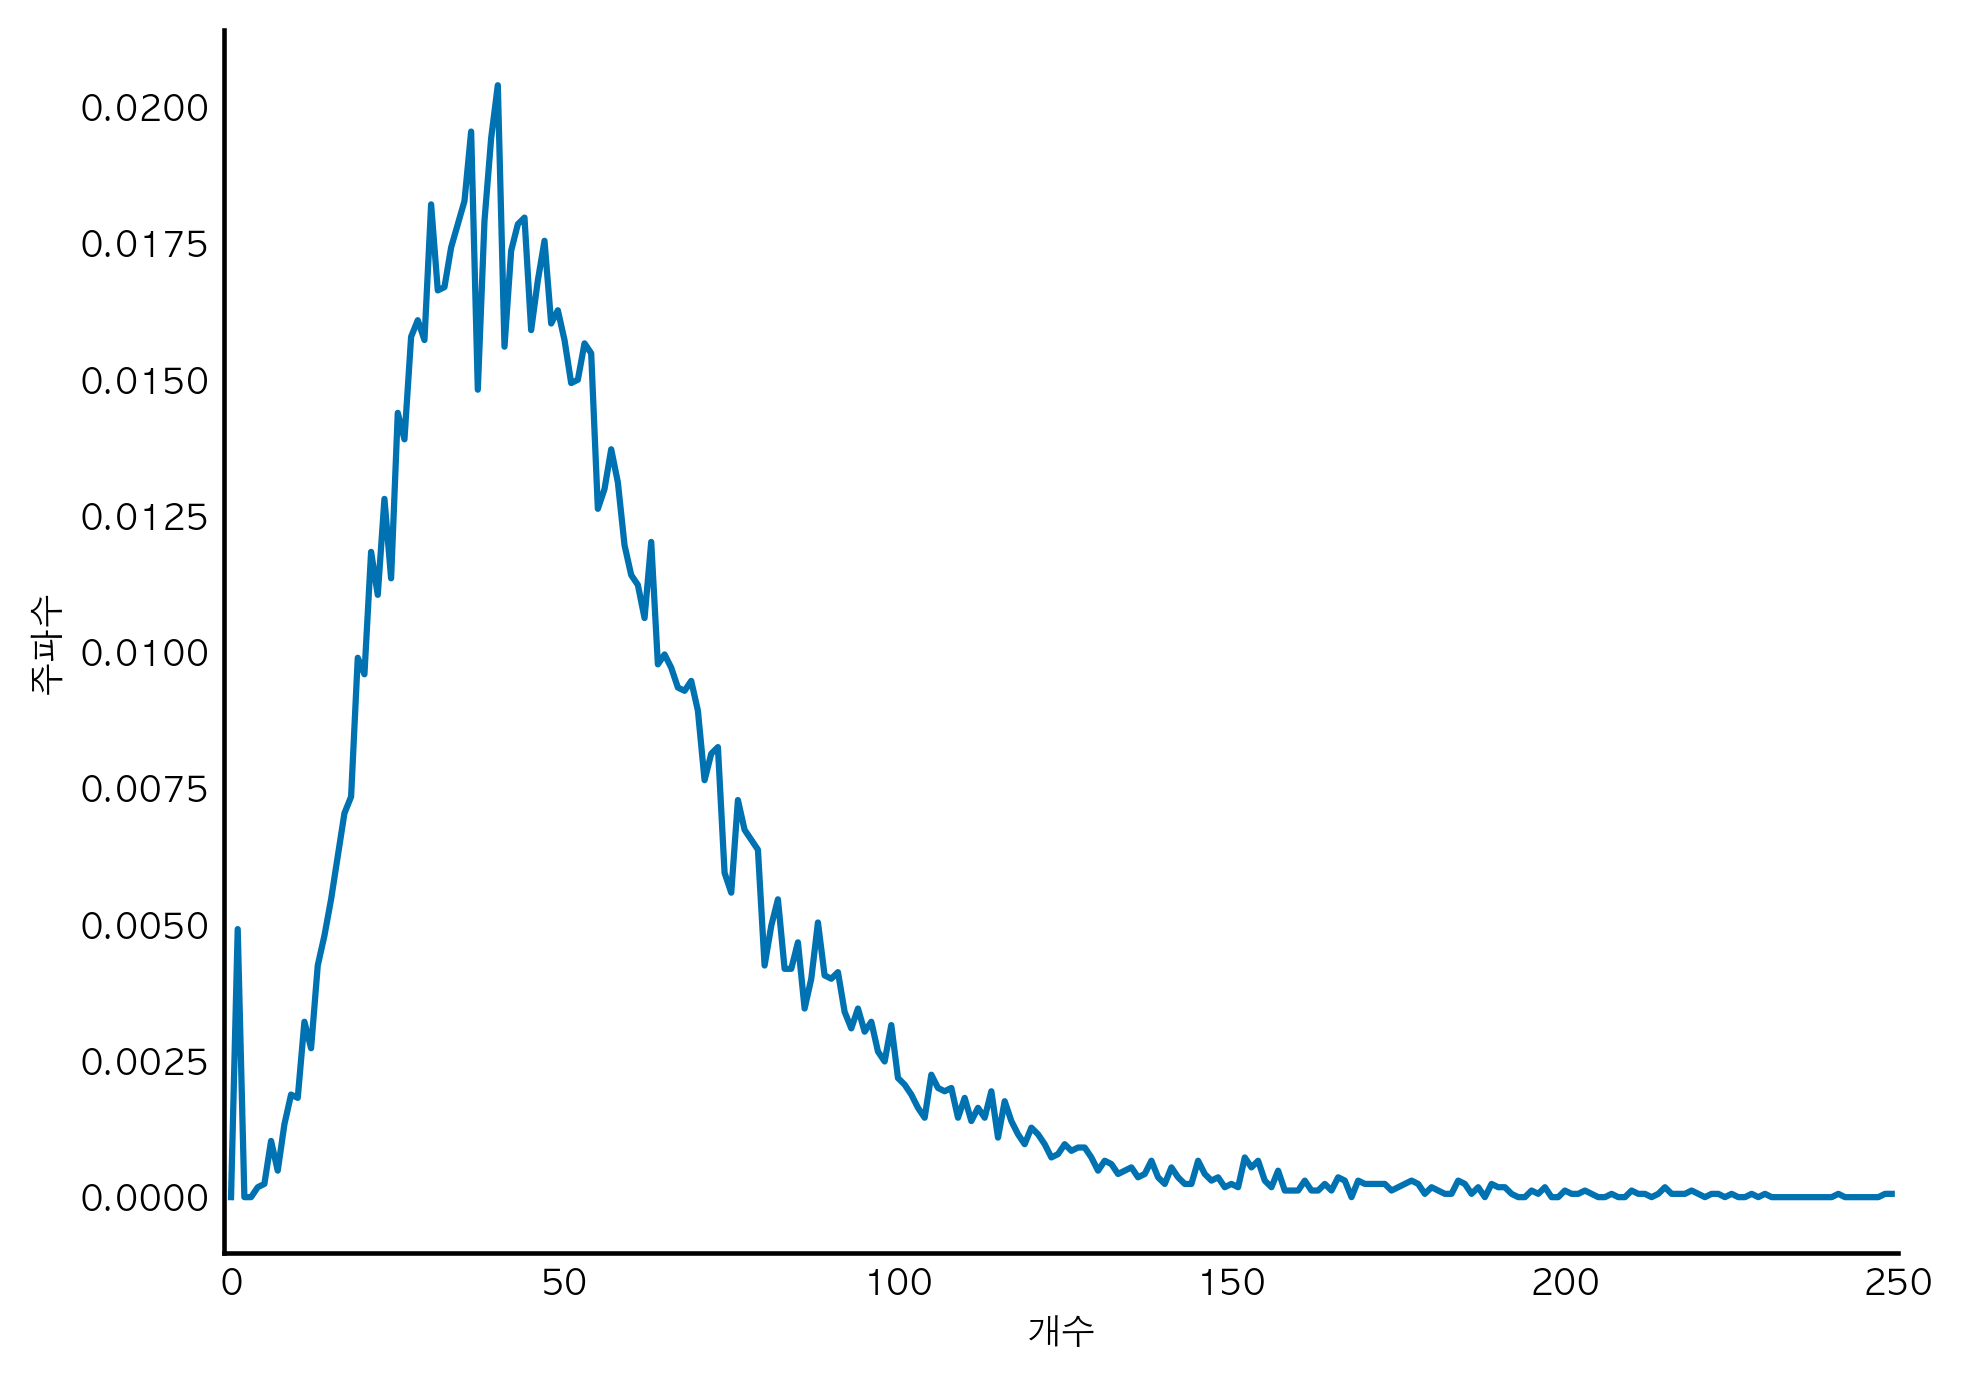

In [31]:
# 그래프를 바로 표시하고, 사용자 정의 스타일을 적용한다.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

def integer_histogram(counts, normed=True, xlim=[], ylim=[],
                      *args, **kwargs):
    hist = np.bincount(counts)
    if normed:
        hist = hist / np.sum(hist)
    fig, ax = plt.subplots()
    ax.plot(np.arange(hist.size), hist, *args, **kwargs)
    ax.set_xlabel('개수')
    ax.set_ylabel('주파수')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

counts_arr = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts_arr, xlim=(-1, 250))

In [14]:
print(tz.sliding_window.__doc__)

 A sequence of overlapping subsequences

    >>> list(sliding_window(2, [1, 2, 3, 4]))
    [(1, 2), (2, 3), (3, 4)]

    This function creates a sliding window suitable for transformations like
    sliding means / smoothing

    >>> mean = lambda seq: float(sum(seq)) / len(seq)
    >>> list(map(mean, sliding_window(2, [1, 2, 3, 4])))
    [1.5, 2.5, 3.5]
    


In [15]:
from toolz import curried as c

k= 7
counts = tz.pipe('data/sample.fasta', open,
                     c.filter(is_sequence),
                     c.map(str.rstrip),
                     c.map(c.sliding_window(k)),
                     tz.concat, c.map(''.join),
                     tz.frequencies)

## 8.4 커링 : 스트리밍의 묘미

In [16]:
def add(a, b):
    return a + b

add(2, 5)

7

In [18]:
def add_curried(a, b=None):
    if b is None:
        # 두 번째 인자가 없으면, 함수를 만들어서 반환한다.
        def add_partial(b):
            return add(a, b)
        return add_partial
    else:
        # 두 인자가 모두 주어지면, 값을 반환한다.
        return add(a, b)

add_curried(2, 5)

7

In [19]:
add_curried(2)

<function __main__.add_curried.<locals>.add_partial>

In [20]:
add2 = add_curried(2)
add2(5)

7

In [21]:
import toolz as tz

@tz.curry  # 커링 데코레이터
def add(x, y):
    return x + y

add_partial = add(2)
add_partial(5)

7

In [22]:
from toolz import curried as c

c.map

<class 'map'>

In [23]:
def genome(file_pattern):
    """FASTA 파일 이름 리스트에서 글자 단위로 게놈을 스트리밍한다."""
    return tz.pipe(file_pattern, glob, sorted,  # 파일 이름
                   c.map(open),  # 라인
                   # 모든 파일의 행을 연결
                   tz.concat,
                   # 각 시퀀스 헤더
                   c.filter(is_sequence),
                   # 모든 라인의 문자 연결
                   tz.concat,
                   # 줄바꿈과 ‘N’을 제거한다.
                   c.filter(is_nucleotide))

## 8.5 k-mer 계산 (계속)

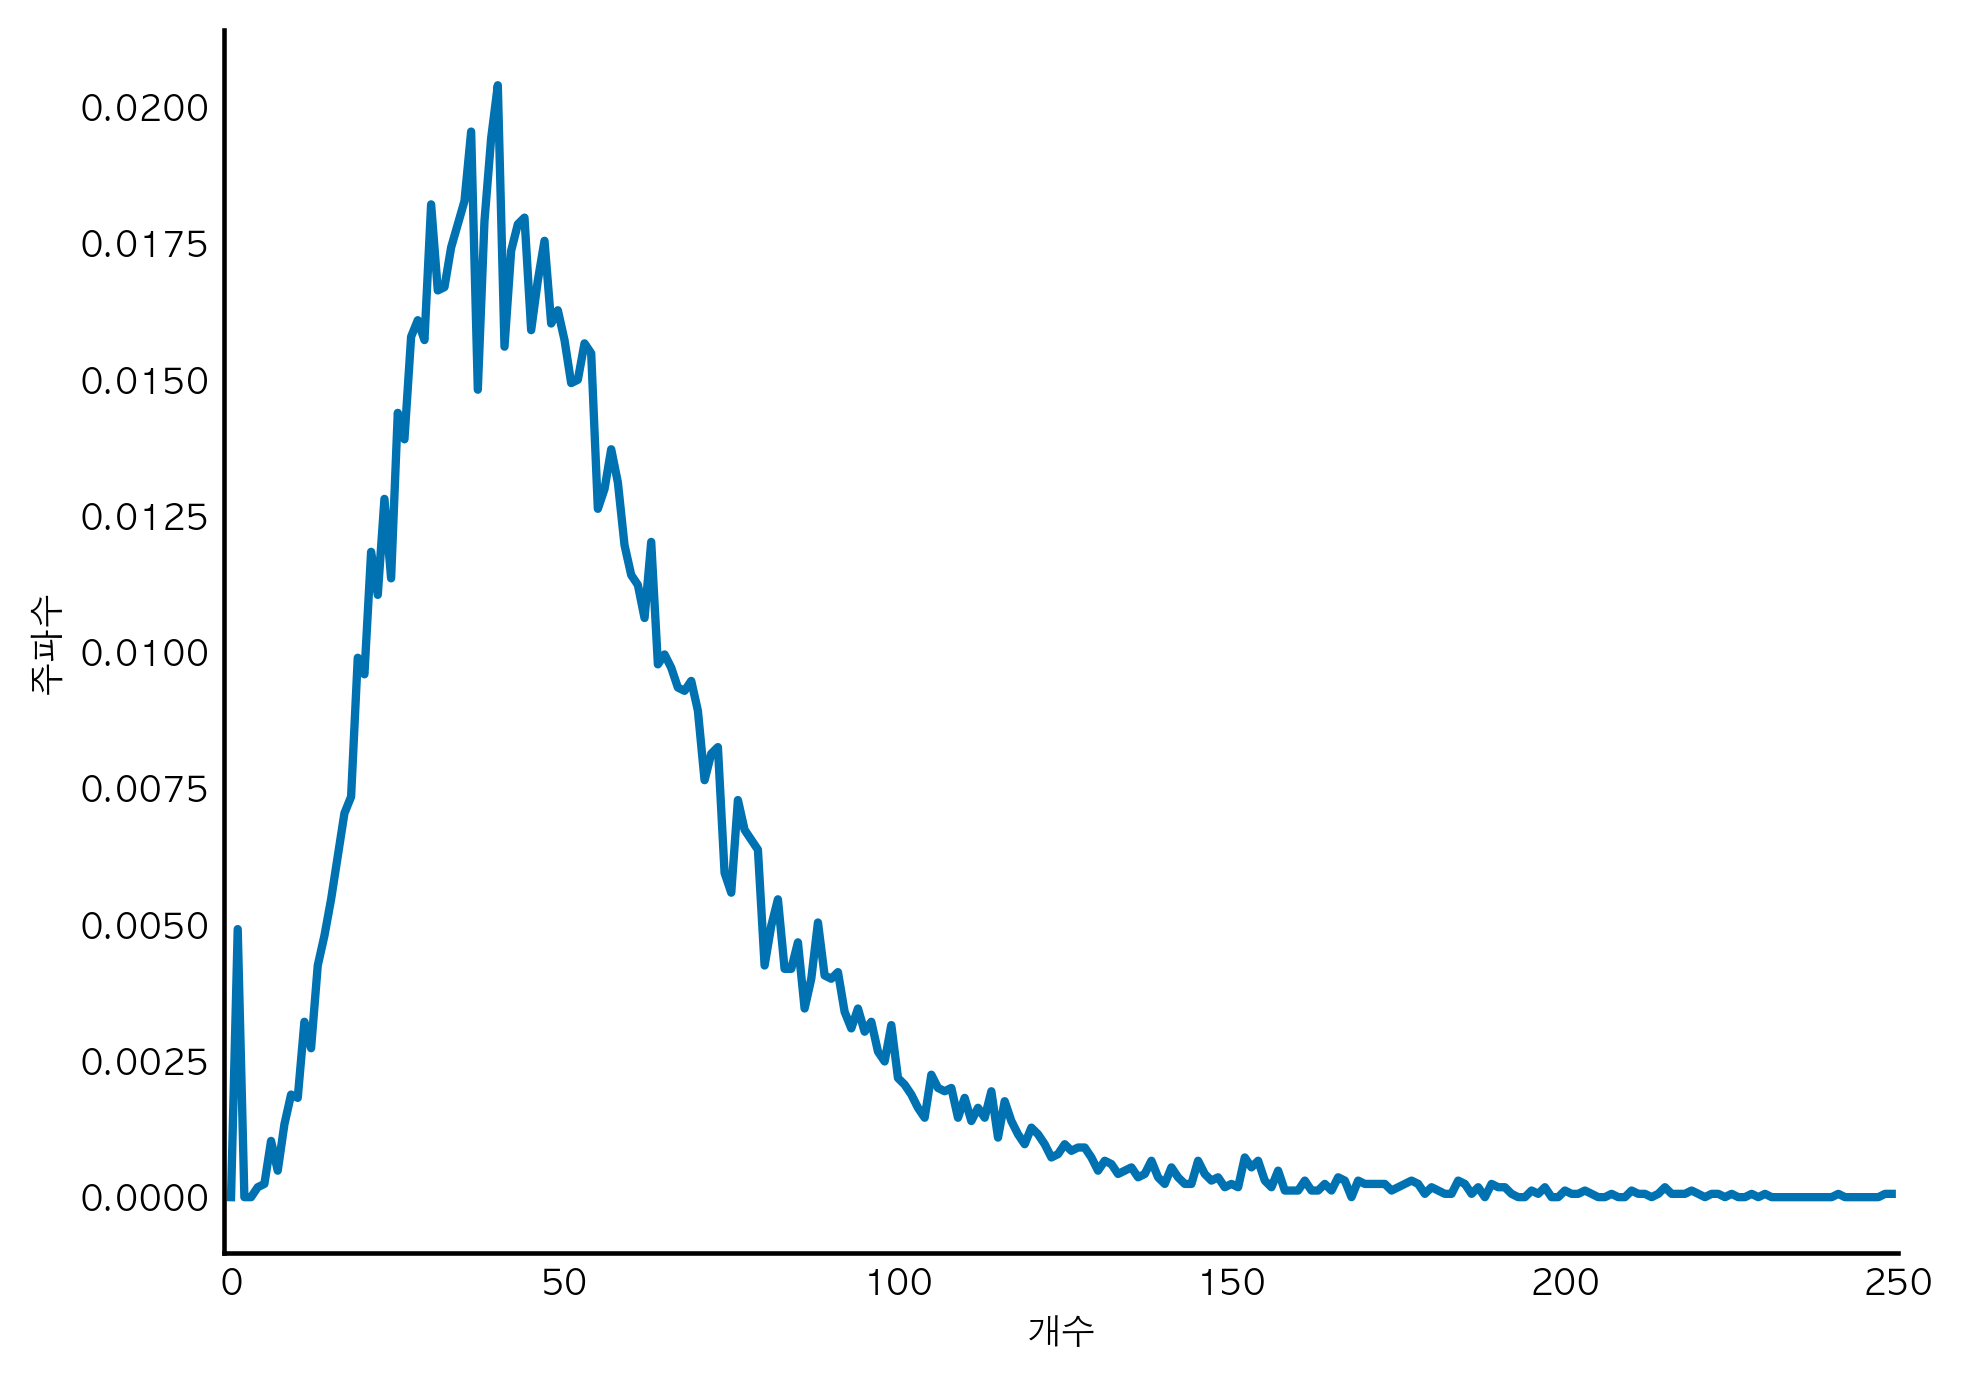

In [32]:
from toolz import curried as c

k= 7
counts = tz.pipe('data/sample.fasta', open,
                 c.filter(is_sequence),
                 c.map(str.rstrip),
                 c.map(c.sliding_window(k)),
                 tz.concat, c.map(''.join),
                 tz.frequencies)

counts = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts, xlim=(-1, 250), lw=2)

### 8.5.1 연습문제 : 스트리밍 데이터와 PCA

## 8.6 게놈의 마르코프 모델

In [34]:
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

In [35]:
def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

In [36]:
import toolz as tz

@tz.curry
def increment_model(model, index):
    model[index] += 1

In [37]:
from toolz import curried as c

def markov(seq):
    """뉴클레오타이드 시퀀스로부터 1차 마르코프 모델을 구한다."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # 각 연속된 튜플
                    c.map(PDICT.__getitem__),   # 튜플의 행렬 위치
                    c.map(increment_model(model))))  # 증가 행렬
    # 개수를 추이 확률 행렬로 변환한다.
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [38]:
from glob import glob

def genome(file_pattern):
    """FASTA 파일 이름 리스트에서 글자 단위로 게놈을 스트리밍한다."""
    return tz.pipe(file_pattern, glob, sorted,  # 파일 이름
                   c.map(open),  # 라인
                   # 모든 파일의 행을 연결
                   tz.concat,
                   # 각 시퀀스 헤더
                   c.filter(is_sequence),
                   # 모든 라인의 문자 연결
                   tz.concat,
                   # 줄바꿈과 ‘N’을 제거한다.
                   c.filter(is_nucleotide))

In [40]:
# ftp://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/dm6.fa.gz
# 위에서 파일을 내려받는다.
# ‘gzip -d dm6.fa.gz’ 명령으로 압축을 푼다
dm = 'data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# 속도를 높이기 위해서, take() 함수를 사용하여, 처음 1000만 염기를 실행한다.
# take() 함수를 사용하지 않으면, 5-10분 기다려야 한다.
print('    ', '      '.join('ACGTacgt'), '\n')
print(model)


     A      C      G      T      a      c      g      t 

[[   nan    nan    nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan]
 [ 0.     0.     0.     0.     0.667  0.333  0.     0.   ]
 [ 0.     0.     0.     0.     0.75   0.25   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.   ]
 [ 0.     0.     0.     0.     0.     0.25   0.5    0.25 ]]


/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


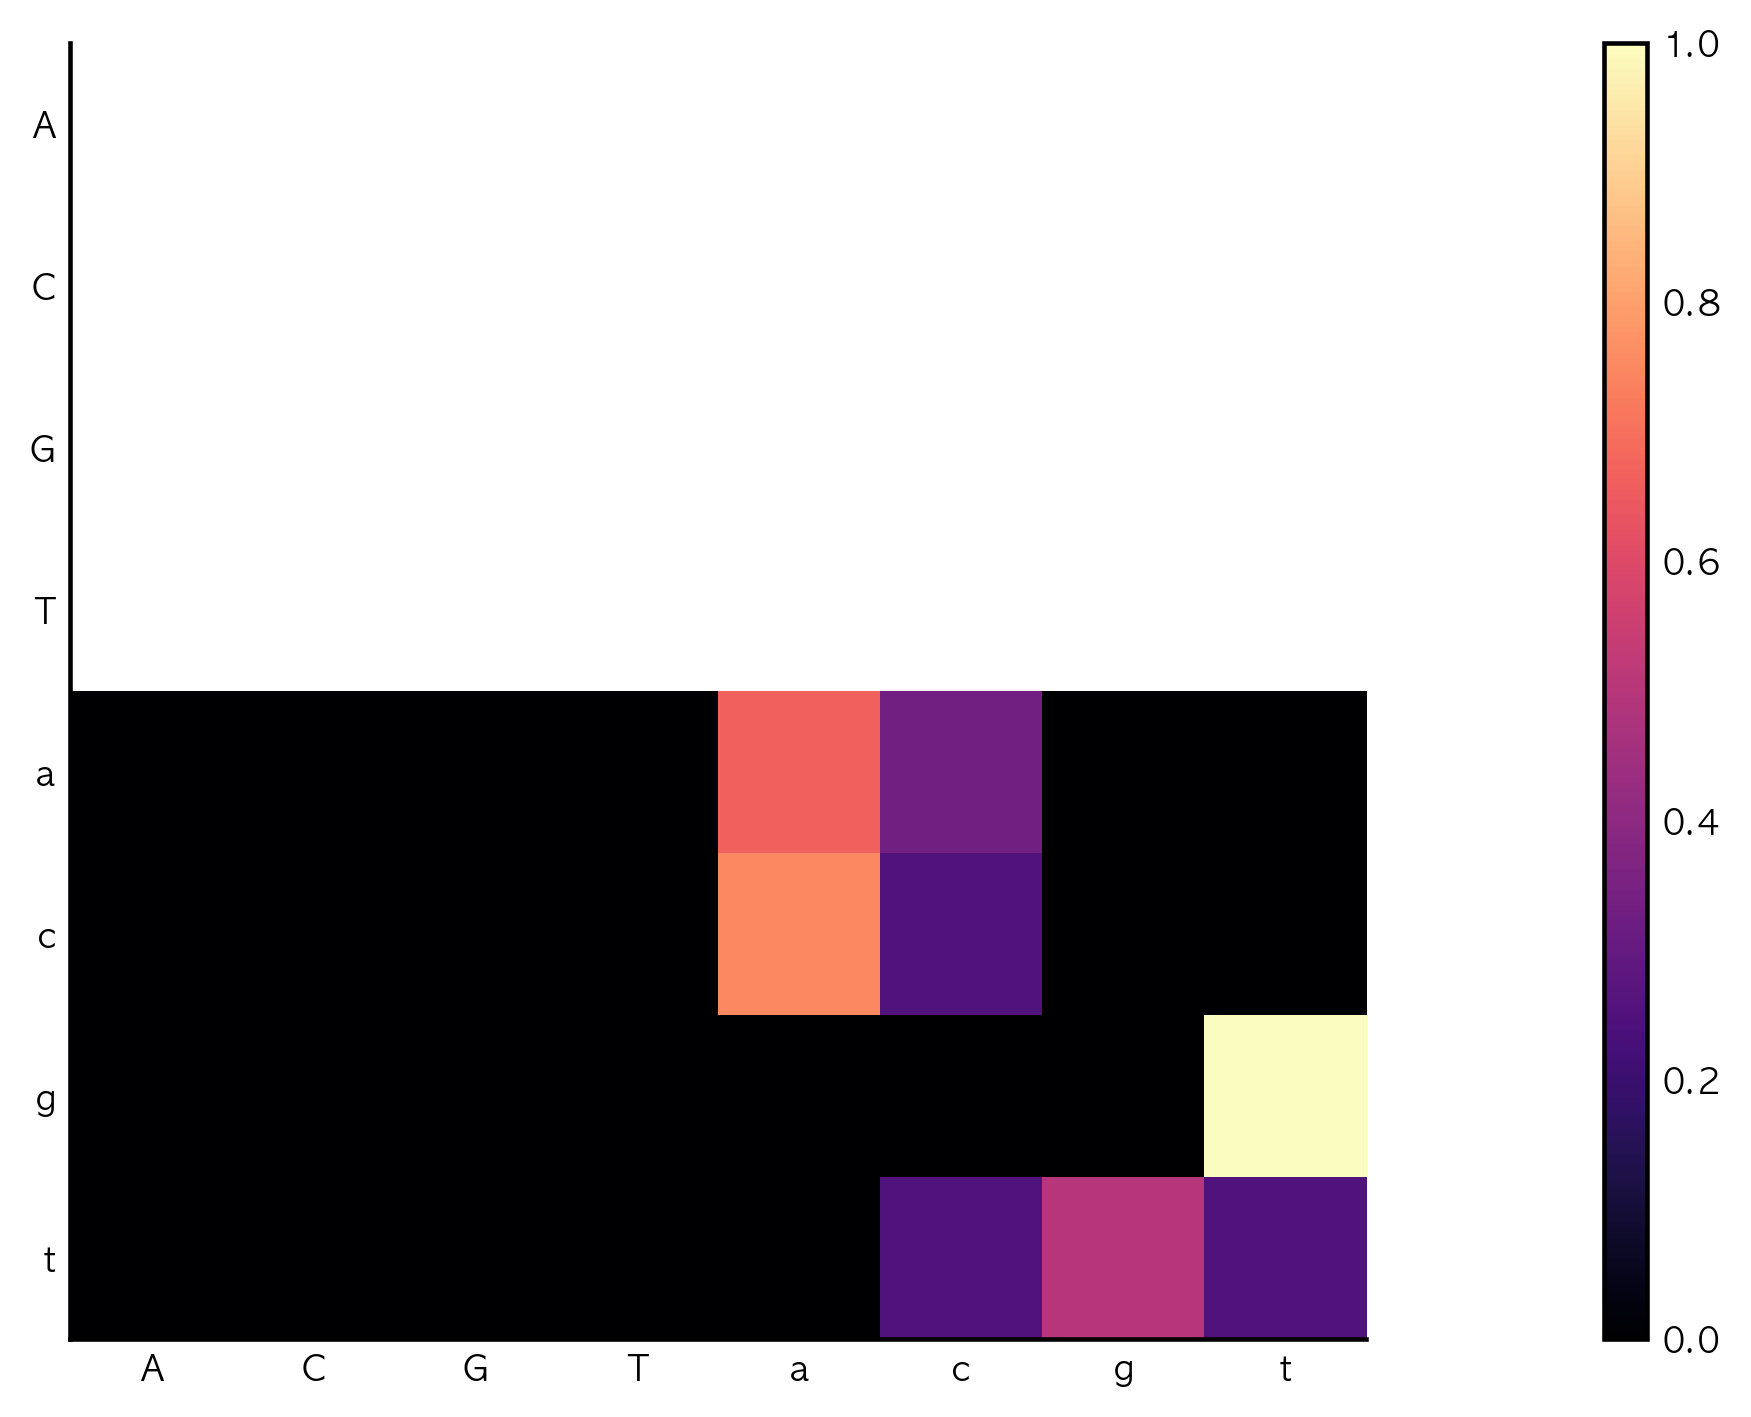

In [41]:
def plot_model(model, labels, figure=None):
    fig = figure or plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    im = ax.imshow(model, cmap='magma');
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    plt.colorbar(im, cax=axcolor)

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(range(8))
        axis.set_ticks_position('none')
        axis.set_ticklabels(labels)
    return ax

plot_model(model, labels='ACGTacgt');

### 8.6.1 연습문제 : 온라인 압축풀기